In [163]:
import pickle
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt

# import pulsee.plot as vis

import tomography.operators as op
from tomography.global_constants import DPI_SAVE, DPI_DISPLAY
from tomography.coeff_groups_class import clean_dm

from tomography.tomography_helper_functions import multiply_error_matrix, tr_error, fortunato_error

from tomography.plot_dm import plot_complex_density_matrix

plt.rcParams['figure.dpi'] = DPI_DISPLAY
plt.rcParams['font.family'] = ['Helvetica']
# matplotlib.rcParams['svg.fonttype'] = 42
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [164]:
CNOT = op.CNOT

In [165]:
FILE_TYPE = "pdf"
FIGURE_FOLDER = f"C:/Users/lemon/OneDrive - Brown University/CNOT project/Publication/images/result_figure/{FILE_TYPE}"
LABEL_SIZE = 16


# Making the Bar Plot

## First need to organize the data into a dictionary

In [166]:
fn_1000 = r"C:\Users\lemon\OneDrive - Brown University\CNOT project\tomography\ADP\2024_02_06\result_1000_V6"
fn_1000_CNOT = r"C:\Users\lemon\OneDrive - Brown University\CNOT project\tomography\ADP\2024_02_06\result_1000_CNOT_V6"
fn_0100 = r"C:\Users\lemon\OneDrive - Brown University\CNOT project\tomography\ADP\2024_02_28\result_0100_V6"
fn_0100_CNOT = r"C:\Users\lemon\OneDrive - Brown University\CNOT project\tomography\ADP\2024_02_28\result_0100_CNOT_V6"
fn_0010 = r"C:\Users\lemon\OneDrive - Brown University\CNOT project\tomography\ADP\2024_02_28\result_0010_V6"
fn_0010_CNOT = r"C:\Users\lemon\OneDrive - Brown University\CNOT project\tomography\ADP\2024_02_27\result_0010_CNOT_V6"
fn_0001 = r"C:\Users\lemon\OneDrive - Brown University\CNOT project\tomography\ADP\2024_02_14\result_0001"
fn_0001_CNOT = r"C:\Users\lemon\OneDrive - Brown University\CNOT project\tomography\ADP\2024_02_14\result_0001_CNOT"

state_fns = [fn_1000, fn_1000_CNOT, fn_0100, fn_0100_CNOT, fn_0010, fn_0010_CNOT, fn_0001, fn_0001_CNOT]

### Getting Projections and their uncertainties

In [167]:
rhos = []
rhos_err = []
projections = []

for fn in state_fns:
    with open(f"{fn}.pickle", "rb") as result_file:
        data = pickle.load(result_file)
        rhos.append(data[0])
        projections.append(data[1])
        
    with open(f"{fn}_error.pickle", "rb") as error_file:
        rhos_err.append(pickle.load(error_file))
        
projections = np.array(projections)
projections

array([0.99058505, 0.95238513, 0.98033053, 0.94945766, 0.97697736,
       0.95211621, 0.98254502, 0.91559573])

In [168]:
projections_err = []
rhos_perfect = [op.CLEAN_1000, op.CLEAN_1000, op.CLEAN_0100, op.CLEAN_0100,
                op.CLEAN_0010, op.CLEAN_0001, op.CLEAN_0001, op.CLEAN_0010]

for rho, rho_err, rho_theo in zip(rhos, rhos_err, rhos_perfect):
    # display(rho)
    # display(rho_err)
    # display(rho_theo)
    projections_err.append(fortunato_error(rho, rho_err, rho_theo, rho_theo * 0))
    
projections_err = np.array(projections_err)
projections_err

array([0.0515602 , 0.06916677, 0.06903608, 0.11067708, 0.03704079,
       0.08337707, 0.06704195, 0.07538996])

### Getting Correlations and their Uncertainties:
- Assuming rho_theo has 0 error


In [169]:
rho_theos = [op.CLEAN_1000, op.CLEAN_0100, op.CLEAN_0001, op.CLEAN_0010]

correlations = []
for i in range(0, len(projections), 2):
    rho_in, rho_out = rhos[i], rhos[i+1]
    # rho_theo = CNOT * rho_in * CNOT.dag()
    rho_theo = rho_theos[i//2]
    c = (rho_theo * rho_out).tr() / np.sqrt((rho_theo ** 2).tr() * (rho_in ** 2).tr())
    correlations.append(c)
    
correlations = np.array(correlations).real
correlations

array([0.99058505, 0.98033053, 0.97697736, 0.94150474])

In [170]:
correlations_err = []
for i in range(0, len(projections), 2):
    rho_in, rho_out = rhos[i], rhos[i+1]
    rho_in_err, rho_out_err = rhos_err[i], rhos_err[i + 1]
    # rho_theo = CNOT * rho_in * CNOT.dag()
    rho_theo = rho_theos[i//2]
    
    numer = (rho_theo * rho_out).tr()
    denom = np.sqrt((rho_theo ** 2).tr() * (rho_in ** 2).tr())
    c = numer / denom
    
    err_numer = tr_error(multiply_error_matrix(rho_theo, rho_theo * 0, rho_out, rho_out_err))
    err_denom_0 = (rho_theo ** 2).tr() * tr_error(multiply_error_matrix(rho_in, rho_in_err, rho_in, rho_in_err))
    err_denom = err_denom_0 * 1/2 / np.sqrt(denom)

    err_c = c * np.sqrt((err_numer / numer) ** 2 + (err_denom / denom) ** 2)
    correlations_err.append(err_c)
    
correlations_err = np.array(correlations_err)
correlations_err

array([0.06566592, 0.09906243, 0.07383953, 0.0744348 ])

In [171]:
all_data = {
    "Input Fidelity": projections[::2], # even elements
    "Output Fidelity": projections[1::2], # odd elements
    "Attenuated Correlation": correlations
}
all_data

{'Input Fidelity': array([0.99058505, 0.98033053, 0.97697736, 0.98254502]),
 'Output Fidelity': array([0.95238513, 0.94945766, 0.95211621, 0.91559573]),
 'Attenuated Correlation': array([0.99058505, 0.98033053, 0.97697736, 0.94150474])}

### Calculating fidelity and its uncertainty:

In [172]:
fidelity = np.mean(correlations)
fidelity_err = np.sqrt(np.sum(correlations_err ** 2)) / len(correlations)

display(fidelity, fidelity_err)

0.9723494186276612

0.03962180094136642

## Choosing the color of the bars

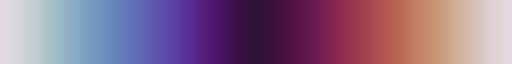

In [173]:
cmap = matplotlib.colormaps.get_cmap('twilight')
display(cmap)
color_offset = 0.1
# colors = [cmap(color_offset + i/3) for i in range(3)]
colors = [cmap(0.15), cmap(0.3), cmap(0.7)]

## Plotting:

In [174]:
for x, y in all_data.items():
    print(x, y)

Input Fidelity [0.99058505 0.98033053 0.97697736 0.98254502]
Output Fidelity [0.95238513 0.94945766 0.95211621 0.91559573]
Attenuated Correlation [0.99058505 0.98033053 0.97697736 0.94150474]


In [214]:
fig_width = 6
fig_height = 5.5
fig_height

5.5

[0. 1. 2. 3.]
[0.2 1.2 2.2 3.2]
[0.4 1.4 2.4 3.4]


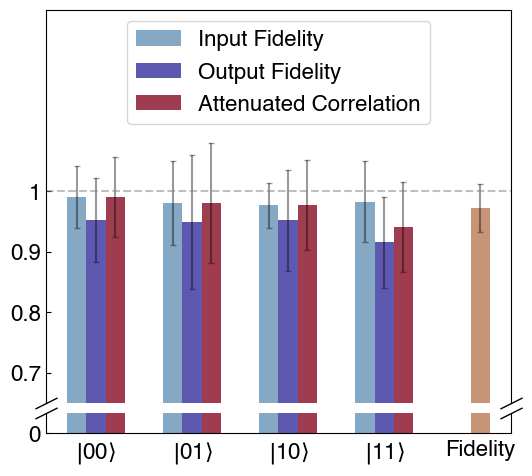

In [216]:
# code adapted from https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html and
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/broken_axis.html

""" SET UP: """

# Making a broken y-axis such that we can skip the 'boring' part of the plot: (0 ~ 0.8)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(fig_width, fig_height), sharex=True, height_ratios=[20, 1])
fig.subplots_adjust(hspace=0.05) # adjust space between axes
# ax2.set_xlabel("States", fontsize=LABEL_SIZE)
# ax1.set_title(" ", y=1.2)
# ax.set_title("Results for full set of input & output states", fontsize=14)

# plot bars on the two axes
# input_states = [r"$|00\rangle$", r"$|01\rangle$", r"$|10\rangle$", r"$|11\rangle$"]
input_states = [r"$|$00$\rangle$", r"$|$01$\rangle$", r"$|$10$\rangle$", r"$|$11$\rangle$"]
xs = np.arange(len(input_states))
width = 0.2
index = 0

errors_all = np.concatenate((projections_err[::2], projections_err[1::2], correlations_err))
x_err_pos = []
y_err_pos = []
ERROR_BAR_COLOR = 'black'
ERROR_ALPHA = 0.4

""" PLOTTING: """

# the main 12 bars:
for attribute, measurement in all_data.items():
    offset = width * index
    ax1.bar(xs + offset, measurement, width, label=attribute, color=colors[index])
    ax2.bar(xs + offset, measurement, width, label=attribute, color=colors[index])
    x_err_pos.append(xs + offset)
    y_err_pos.append(measurement)
    index += 1
    print(xs+offset)
    
# error on the 12 bars:
# In the order of [in_proj_1, in_proj2, in_proj_3, in_proj_4, out_proj_1, out_proj_2, out_proj_3, out_proj_4, corr_1, ...] 
x_err_pos = np.array(x_err_pos).flatten()
y_err_pos = np.array(y_err_pos).flatten()
ax1.errorbar(x_err_pos, y_err_pos, fmt='none', yerr=errors_all, capsize=2, color=ERROR_BAR_COLOR, alpha=ERROR_ALPHA)
    
    
# plot the fidelity bar
fidelity_color = cmap(0.85)
fidelity_xpos = xs[-1] + 1.2
offset_fidelity = width * index
ax1.bar(fidelity_xpos, fidelity, width, color=fidelity_color)
ax2.bar(fidelity_xpos, fidelity, width, color=fidelity_color)
# fidelity error bar
ax1.errorbar(fidelity_xpos, fidelity, fmt='none', yerr=fidelity_err, capsize=2, color=ERROR_BAR_COLOR, alpha=ERROR_ALPHA)



ax1.set_ylim(0.65, 1.3)  # change this to change the proportion of the bar heights
ax2.set_ylim(0, 0.1)

# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.tick_params(bottom=False)
ax2.xaxis.tick_bottom()

# Now, let's turn towards the cut-out slanted lines.
# We create line objects in axes coordinates, in which (0,0), (0,1),
# (1,0), and (1,1) are the four corners of the axes.
# The slanted lines themselves are markers at those locations, such that the
# lines keep their angle and position, independent of the axes size or scale
# Finally, we need to disable clipping.

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=LABEL_SIZE,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)


ax1.tick_params('y', direction='in')
ax1.set_yticks([0.7, 0.8, 0.9, 1], [0.7, 0.8, 0.9, 1], fontsize=LABEL_SIZE)


xticks_pos = list(xs + width) + [fidelity_xpos]
# print(xticks_pos)
ax2.tick_params('x', length=0, pad=5)
ax2.set_xticks(xticks_pos, input_states + ["Fidelity"], fontsize=LABEL_SIZE)
ax2.tick_params('y', direction='in')
ax2.set_yticks([0], [0], fontsize=LABEL_SIZE)

ax1.legend(loc='upper center', fontsize=LABEL_SIZE)

# Draw a horizontal line across y=1
ax1.axhline(1, linestyle='--', color='gray', alpha=0.5)
plt.savefig(f"{FIGURE_FOLDER}/result_bar_plot_6_by_5p5.{FILE_TYPE}", transparent=True, dpi=DPI_SAVE, bbox_inches = 'tight')

In [177]:
# for rho in rhos:
#     vis.plot_complex_density_matrix(rho, label_qubit=True, label_size=LABEL_SIZE, fig_dpi=DPI_SAVE, show_legend=False)

# Making the Density Matrix Plots

Helper `wrapper` function to save DMs in a consistent format

In [178]:
def dm_savefig_wrapper(dm, name, file_type=FILE_TYPE, show_phase=False, folder_name=FIGURE_FOLDER):
    fig_dm, ax_dm = plot_complex_density_matrix(dm, label_qubit=True, label_size=LABEL_SIZE, fig_dpi=DPI_SAVE, show_legend=show_phase, show=False, add_shade=False)
    fig_dm.savefig(f"{folder_name}/{name}.{file_type}", transparent=True, dpi=DPI_SAVE, bbox_inches='tight')


## Measured & Theoretical of 4 inputs & outputs.

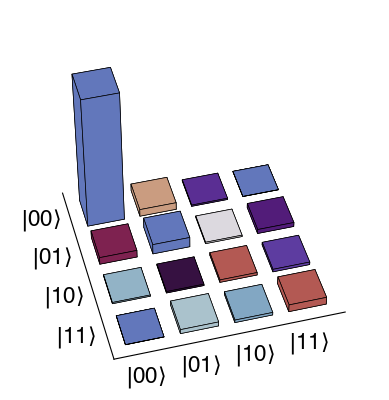

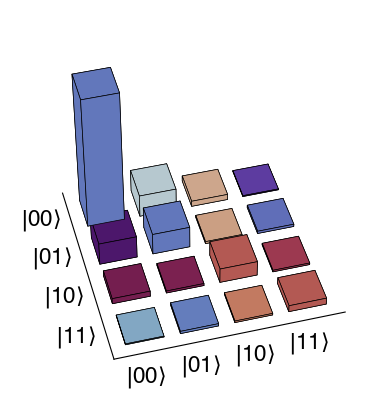

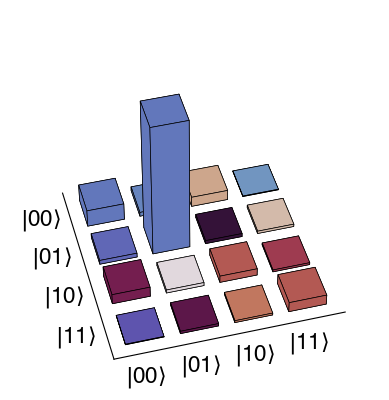

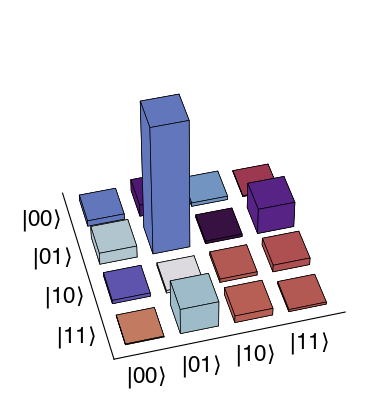

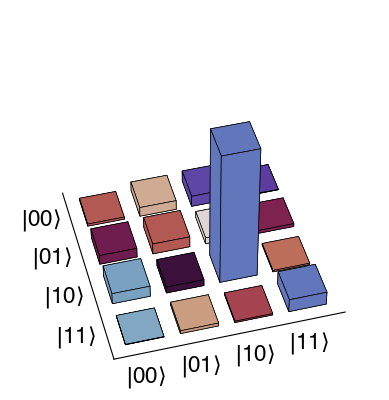

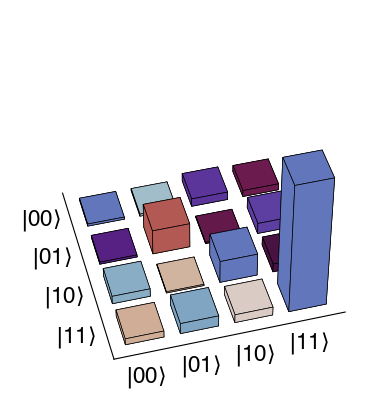

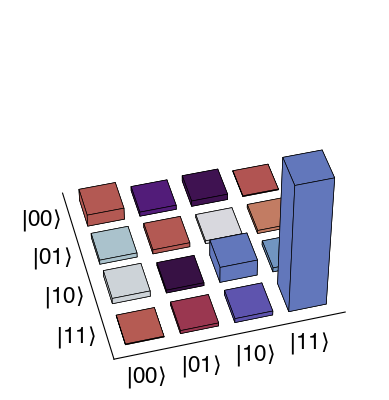

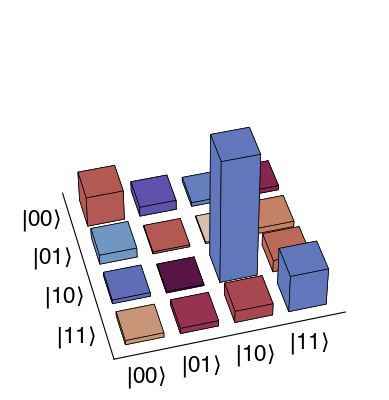

In [179]:
rhos_names = ["1000_meas", "1000_CNOT_meas", "0100_meas", "0100_CNOT_meas",
              "0010_meas", "0010_CNOT_meas", "0001_meas", "0001_CNOT_meas"]

for i in range(len(rhos)):
    dm_savefig_wrapper(rhos[i], rhos_names[i], FILE_TYPE)

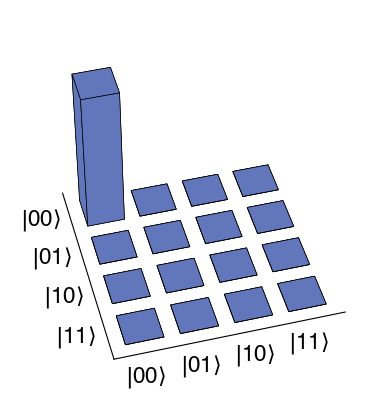

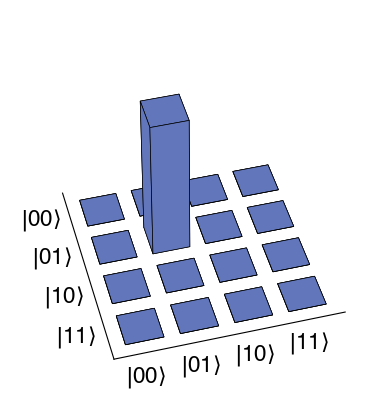

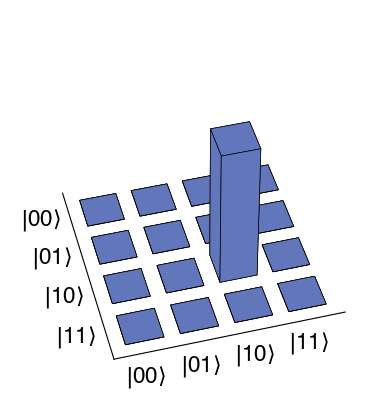

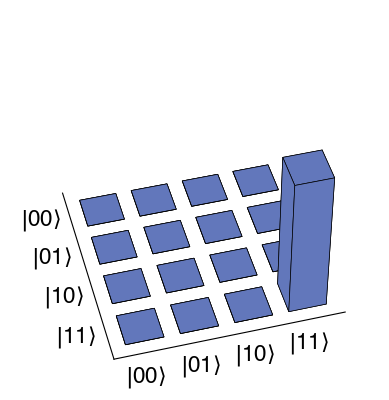

In [180]:
theory_names = ["1000_theory", "0100_theory", "0010_theory", "0001_theory"]
theory_rhos = [op.CLEAN_1000, op.CLEAN_0100, op.CLEAN_0010, op.CLEAN_0001]

for i in range(len(theory_names)):
    dm_savefig_wrapper(theory_rhos[i], theory_names[i], FILE_TYPE)


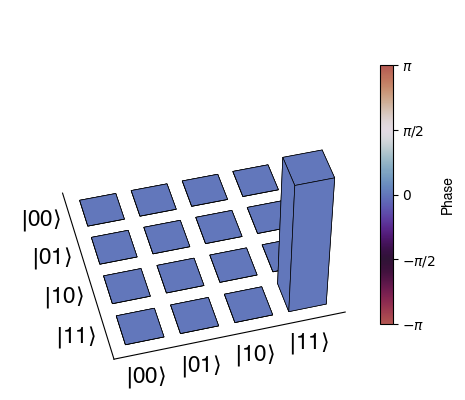

In [181]:
dm_savefig_wrapper(op.CLEAN_0001, "phase_legend", FILE_TYPE, show_phase=True)

# Bell Figure Maker

## Measured & Theoretical of:
- 1000 + Hadamard
- 1000 + Hadamard + T
- 1000 + Hadamard + CNOT (Bell State)

### 1000 + Hadamard

In [182]:
op.H_1 * op.CLEAN_1000 * op.H_1.dag()

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.5 0.  0.5 0. ]
 [0.  0.  0.  0. ]
 [0.5 0.  0.5 0. ]
 [0.  0.  0.  0. ]]

In [183]:
BELL_FIGURE_FOLDER = f"C:/Users/lemon/OneDrive - Brown University/CNOT project/Publication/images/Bell_figure/{FILE_TYPE}"

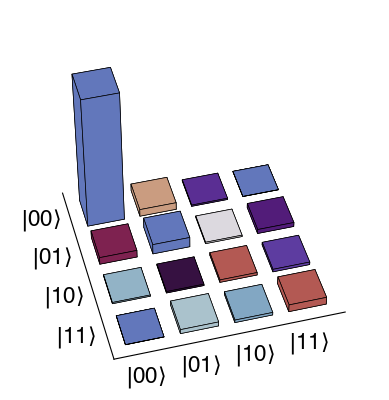

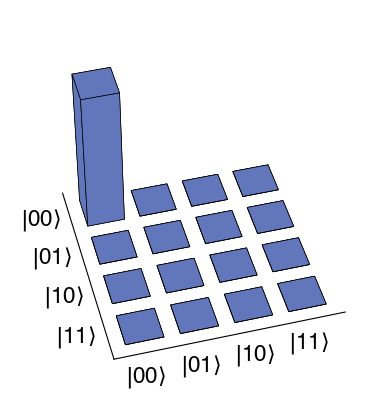

In [184]:
dm_savefig_wrapper(rhos[0], rhos_names[0], FILE_TYPE, folder_name=BELL_FIGURE_FOLDER)
dm_savefig_wrapper(theory_rhos[0], theory_names[0], FILE_TYPE, folder_name=BELL_FIGURE_FOLDER)

Projection is: 0.9855474148287415, error: 0.118


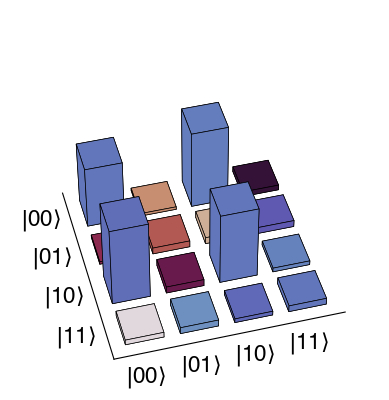

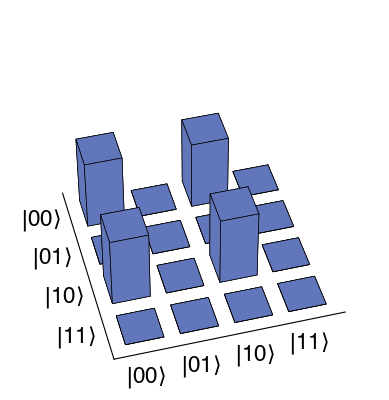

In [185]:
fn_had = r"C:\Users\lemon\OneDrive - Brown University\CNOT project\tomography\ADP\2024_05_30\result_Had_ns32"

with open(f"{fn_had}.pickle", "rb") as result_file:
    data = pickle.load(result_file)
    rho_had = data[0]
    proj_had = data[1]
    
with open(f"{fn_had}_error.pickle", "rb") as error_file:
    rho_had_err = pickle.load(error_file)
    
rho_had_theory = op.H_1 * op.CLEAN_1000 * op.H_1.dag()
proj_had_err = fortunato_error(rho_had, rho_had_err, rho_had_theory, rho_had_theory * 0)    
    
dm_savefig_wrapper(rho_had, "10000+H_meas", FILE_TYPE, folder_name=BELL_FIGURE_FOLDER)
dm_savefig_wrapper(rho_had_theory, "1000+H_theory", FILE_TYPE, folder_name=BELL_FIGURE_FOLDER)
# plot_complex_density_matrix(rho_had_err)
print(f"Projection is: {proj_had}, error: {proj_had_err:.3f}")

### 1000 + Hadamard + T

In [186]:
# fn_had_t = r"C:\Users\lemon\OneDrive - Brown University\CNOT project\tomography\ADP\2024_05_30\result_Had+T_ns2"
# 
# with open(fn_had_t, "rb") as result_file:
#     data = pickle.load(result_file)
#     rho_had_t = data[0]
#     proj_had_t = data[1]
#     
# dm_savefig_wrapper(rho_had_t, "0001+H+T_meas")
# dm_savefig_wrapper((op.T * op.H_1 * op.CLEAN_1000 * op.H_1.dag() * op.T.dag()).unit(), "0001+H+T_theory")
# print(f"Projection is: {proj_had_t}")

### Bell State

Projection is: 0.952, error: 0.089


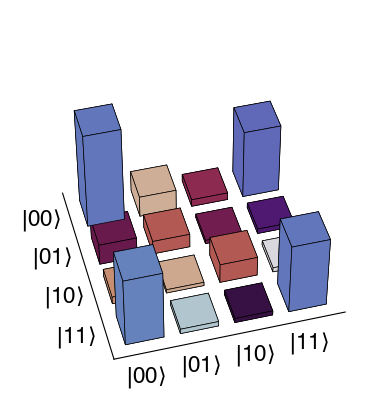

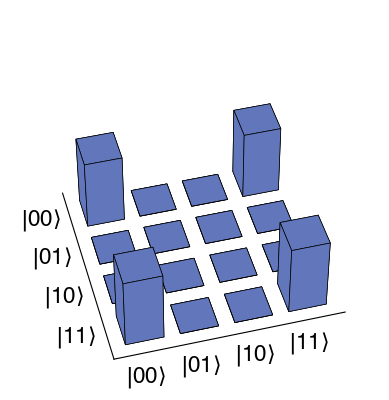

In [187]:
fn_bell = r"C:\Users\lemon\OneDrive - Brown University\CNOT project\tomography\ADP\2024_05_30\result_Bell_ns2"

with open(f"{fn_bell}.pickle", "rb") as result_file:
    data = pickle.load(result_file)
    rho_bell = data[0]
    proj_bell = data[1]
    
with open(f"{fn_bell}_error.pickle", "rb") as error_file:
    rho_bell_err = pickle.load(error_file)

rho_bell_theory = (op.CNOT * op.H_1 * op.CLEAN_1000 * op.H_1.dag() * op.CNOT.dag())
proj_bell_err = fortunato_error(rho_bell, rho_bell_err, rho_bell_theory, rho_bell_theory * 0)    

dm_savefig_wrapper(rho_bell, "bell_meas", folder_name=BELL_FIGURE_FOLDER)
dm_savefig_wrapper(rho_bell_theory, "bell_theory", folder_name=BELL_FIGURE_FOLDER)
print(f"Projection is: {proj_bell:.3f}, error: {proj_bell_err:.3f}")

# Summarizing everything into a .txt file

In [188]:
projection_names = ["1000 input", "1000 output", "0100 input", "0100 output",
                    "0010 input", "0010 output", "0001 input", "0001 output"]

corr_names = ["1000", "0100", "0010", "0001"]

with open(r"C:\Users\lemon\OneDrive - Brown University\CNOT project\Publication\images\result_figure\results_values.txt", "w") as f:
    f.write("CNOT:\n")
    for i in range(len(projections)):
        f.write(f"Projection {projection_names[i]}: {projections[i]:.3f} error: {projections_err[i]:.3f}\n")
    for i in range(len(correlations)):
        f.write(f"Correlation {corr_names[i]}: {correlations[i]:.3f} error: {correlations_err[i]:.3f}\n")
    f.write("\n")
    f.write(f"CNOT Fidelity: {fidelity:.3f} error: {fidelity_err:.3f}\n")
    f.write("\n")
    f.write(f"1000 + H Projection: {proj_had:.3f} error {proj_had_err:.3f}\n")
    f.write("\n")
    f.write(f"Pseudo-Bell State Projection: {proj_bell:.3f} error {proj_bell_err:.3f}")

# Plotting two matrices onto one plot

Text(0.5, 0.8280000000000001, 'Option 1:\n Just measured matrix, with shading\n (closest to old version)')

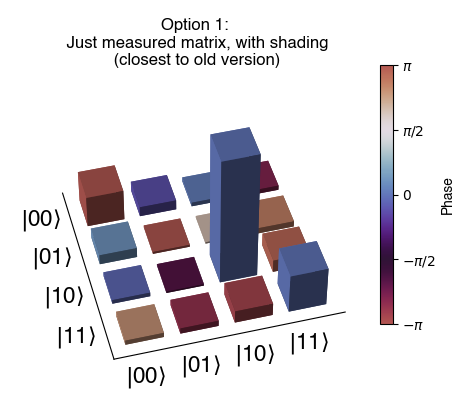

In [189]:
fig_dm, ax_dm = plot_complex_density_matrix(rhos[-1], label_qubit=True, label_size=LABEL_SIZE, fig_dpi=DPI_SAVE, show_legend=True, show=False)

ax_dm.set_title("Option 1:\n Just measured matrix, with shading\n (closest to old version)", y=0.9)
# fig_dm.tight_layout()


Text(0.5, 0.8280000000000001, 'Option 2:\n Just measured matrix, no shading \n (more consistent colors)')

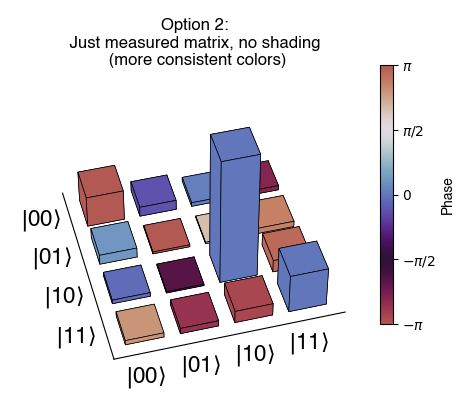

In [190]:
fig_dm, ax_dm = plot_complex_density_matrix(rhos[-1], label_qubit=True, label_size=LABEL_SIZE, fig_dpi=DPI_SAVE, show_legend=True, show=False, add_shade=False)

ax_dm.set_title("Option 2:\n Just measured matrix, no shading \n (more consistent colors)", y=0.9)



Text(0.5, 0.8280000000000001, 'Option 3:\n Measured and Theory matrix, with shading')

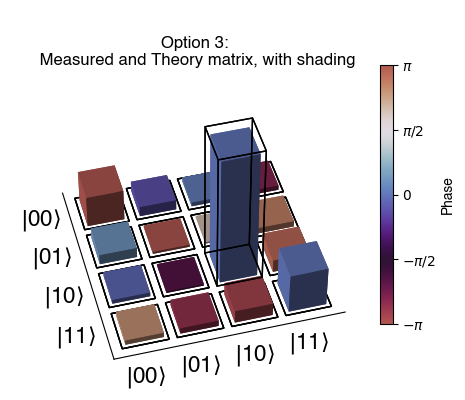

In [191]:
fig_dm, ax_dm = plot_complex_density_matrix(rhos[-1], dm_theory=op.CLEAN_0010, label_qubit=True, label_size=LABEL_SIZE, fig_dpi=DPI_SAVE, show_legend=True, show=False, add_shade=True)

ax_dm.set_title("Option 3:\n Measured and Theory matrix, with shading", y=0.9)

Text(0.5, 0.8280000000000001, 'Option 4:\n Measured and Theory matrix, no shading \n (more consistent colors)')

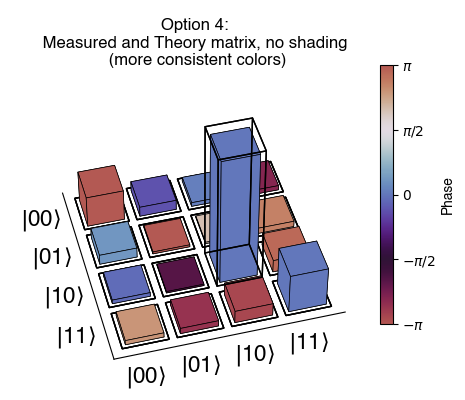

In [192]:
fig_dm, ax_dm = plot_complex_density_matrix(rhos[-1], dm_theory=op.CLEAN_0010, label_qubit=True, label_size=LABEL_SIZE, fig_dpi=DPI_SAVE, show_legend=True, show=False, add_shade=False)

ax_dm.set_title("Option 4:\n Measured and Theory matrix, no shading \n (more consistent colors)", y=0.9)